# Active Testing on Box level

data prepared from prepare_box_data.ipynb
results store in ./results/active_test_box_level

In [1]:
import argparse
import datetime
import json
import random
import time
from pathlib import Path
import os, sys
import numpy as np
import torch

from main import build_model_main
from util.slconfig import SLConfig
from datasets import build_dataset
from util.visualizer import COCOVisualizer
from util import box_ops
import pickle
import copy
import random
from util.utils import slprint, to_device
import util.misc as utils
from engine import evaluate
from torch.utils.data import DataLoader
from datasets import build_dataset, get_coco_api_from_dataset

In [2]:
def read_one_image_results(path):
    with open(path, "r") as outfile:
        data = json.load(outfile)
    return data

def write_one_results(path, json_data):
    with open(path, "w") as outfile:
        json.dump(json_data, outfile)
        
def transform_tensor_to_list(l):
    return l.cpu().tolist()

def transform_tensors_to_list(l):
    if torch.is_tensor(l):
        return transform_tensor_to_list(l)
    if isinstance(l, list):
        r = []
        for i in l:
            r.append(transform_tensors_to_list(i))
        return r
    if isinstance(l, dict):
        r = {}
        for k,v in l.items():
            r[k] = transform_tensors_to_list(v)
        return r
    return l

def LURE_weights_for_risk_estimator(weights, N):
    M = weights.size
    if M < N:
        m = np.arange(1, M+1)
        v = (
            1
            + (N-M)/(N-m) * (
                    1 / ((N-m+1) * weights)
                    - 1
                    )
            )
    else:
        v = 1

    return v

def get_one_annotation_values(path, key, file_num = 5000):
    results = []
    for img_idx in range(file_num):
        file_path = os.path.join(path, str(img_idx)+".json")
        data = read_one_image_results(file_path)
        if data[key] != None:
            results.extend(data[key])
        else:
            # print(f"{file} don't have this data")
            result = [-1]*len(data['loss'])
            results.extend(result)
    return np.array(results)

def get_img_idxes(path, file_num = 5000):
    results = []
    for img_idx in range(file_num):
        file_path = os.path.join(path, str(img_idx)+".json")
        data = read_one_image_results(file_path)
        result = [img_idx] * len(data['loss'])
        results.extend(result)
    return np.array(results)

def acquire(expected_loss_inputs, samples_num):
    assert samples_num <= expected_loss_inputs.size
    expected_loss = np.copy(expected_loss_inputs)
    # Log-lik can be negative.
    # Make all values positive.
    if (expected_loss < 0).sum() > 0:
        expected_loss += np.abs(expected_loss.min())
    
    if np.any(np.isnan(expected_loss)):
        logging.warning(
            'Found NaN values in expected loss, replacing with 0.')
        logging.info(f'{expected_loss}')
        expected_loss = np.nan_to_num(expected_loss, nan=0)
    pick_sample_idxs = np.zeros((samples_num), dtype = int)
    idx_array = np.arange(expected_loss.size)
    weights = np.zeros((samples_num), dtype = np.single)
    uniform_clip_val = 0.2
    for i in range(samples_num):
        expected_loss /= expected_loss.sum()
        # clip all values less than 10 percent of uniform propability
        expected_loss = np.maximum(uniform_clip_val * 1/expected_loss.size, expected_loss)
        expected_loss /= expected_loss.sum()
        sample = np.random.multinomial(1, expected_loss)
        cur_idx = np.where(sample)[0][0]
        # cur_idx = np.random.randint(expected_loss.size)
        pick_sample_idxs[i] = idx_array[cur_idx]
        weights[i] = expected_loss[cur_idx]
        selected_mask = np.ones((expected_loss.size), dtype=bool)
        selected_mask[cur_idx] = False
        expected_loss = expected_loss[selected_mask]
        idx_array = idx_array[selected_mask]
    return pick_sample_idxs, weights

In [3]:
split = "val"
data_path = "./data/5_scale_31/" + split + "/data/"
annotation_path = "./data/5_scale_31/" + split + "/box_annotation/"
result_json_path = "./results/active_test_box_level_pre/"
box_labels_nums = 36335
sample_size_precentage = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]
sample_size_set = (np.array(sample_size_precentage) * box_labels_nums).astype(int).tolist()
# sample_size_set = [50, 100, 150, 200, 250, 500, 750, 1000, 1500, 2000, 3000]
# simple_size_precent = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.15, 0.2, 0.25, 0.3]
random_seed_set = [4519, 9524, 5901, 1028, 6382, 5383, 5095, 7635,  890,  608]

In [4]:
losses = get_one_annotation_values(annotation_path, "loss")
label_idxes = get_one_annotation_values(annotation_path, "matched_target_indexes")
img_idxes = get_img_idxes(annotation_path)

## Random Sample risk estimation

In [5]:
def run_one_random_sample_risk_estimator(true_losses, seed, samples_num):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    perm = np.random.permutation(true_losses.size)
    pick_sample_idxs = perm[:samples_num]
    sampled_true_losses = true_losses[pick_sample_idxs]
    return sampled_true_losses.mean()

In [39]:
# The required label might be repeated
file_path = result_json_path + "random_sample_repeated_R50_31_10_runs.json"
json_object = {}
for sample_size in sample_size_set:
    for seed in random_seed_set:
        result = {"active_test_type": "random sample repeated", "sample_size": sample_size}
        loss_risk = run_one_random_sample_risk_estimator(losses, seed, sample_size)
        result["loss"] = loss_risk
        json_object[len(json_object)] = result
with open(file_path, "w") as outfile:
    json.dump(json_object, outfile)

In [6]:
def run_one_random_sample_without_repeated_risk_estimator(true_losses, img_idxes, label_idxes, seed, samples_num):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    assert true_losses.size == img_idxes.size
    assert true_losses.size == label_idxes.size
    idx_array = np.arange(true_losses.size)
    count = 0
    choose_loss = []
    choose_box_idx = {}
    while count < samples_num:
        idx = np.random.randint(idx_array.size, size=1)
        real_idx = idx_array[idx]
        choose_loss.extend(true_losses[real_idx].tolist())
        img_idx = int(img_idxes[real_idx])
        lable_idx = int(label_idxes[real_idx])
        selected_masked = np.ones(idx_array.shape, dtype=bool)
        selected_masked[idx] = False
        idx_array = idx_array[selected_masked]
        if img_idx in choose_box_idx:
            if lable_idx in choose_box_idx[img_idx]:
                continue
            choose_box_idx[img_idx].append(lable_idx)
        else:
            choose_box_idx[img_idx] = [lable_idx]
        count += 1
    return np.array(choose_loss).mean()

In [41]:
# The required label won't be repeated
file_path = result_json_path + "random_sample_R50_31_10_runs.json"
json_object = {}
for sample_size in sample_size_set:
    for seed in random_seed_set:
        result = {"active_test_type": "random sample", "sample_size": sample_size}
        loss_risk = run_one_random_sample_without_repeated_risk_estimator(losses, img_idxes, label_idxes, seed, sample_size)
        result["loss"] = loss_risk
        json_object[len(json_object)] = result
with open(file_path, "w") as outfile:
    json.dump(json_object, outfile)

## Whole data set risk estimation

In [42]:
def get_whole_data_set_risk_estimator(true_losses):
    return true_losses.mean()

In [43]:
file_path = result_json_path + "None_R50_31.json"
result = {"active_test_type": "None", "sample_size": losses.size}
result["loss"] = get_whole_data_set_risk_estimator(losses)
json_object = {}
json_object[0] = result
with open(file_path, "w") as outfile:
    json.dump(json_object, outfile)

## Try using sklearn model to estimate loss

In [7]:
import json
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import copy
import sklearn
import random
from util.box_ops import box_cxcywh_to_xyxy, generalized_box_iou

In [8]:
def hungarian_matching(out_logits, out_boxes, tgt_ids, tgt_bbox, cost_class = 2.0, cost_bbox = 5.0, cost_giou = 2.0, focal_alpha = 0.25):
    """ Performs the matching
    """
    # We flatten to compute the cost matrices in a batch
    num_queries = out_logits.shape[0]
    out_prob = out_logits.sigmoid()  # [num_queries, num_classes]
    
    # Compute the classification cost.
    alpha = focal_alpha
    gamma = 2.0
    neg_cost_class = (1 - alpha) * (out_prob ** gamma) * (-(1 - out_prob + 1e-8).log())
    pos_cost_class = alpha * ((1 - out_prob) ** gamma) * (-(out_prob + 1e-8).log())
    cost_class = pos_cost_class[:, tgt_ids] - neg_cost_class[:, tgt_ids]
    
    # Compute the L1 cost between boxes
    cost_bbox = torch.cdist(out_boxes, tgt_bbox, p=1)
    
    # Compute the giou cost betwen boxes            
    cost_giou = -generalized_box_iou(box_cxcywh_to_xyxy(out_boxes), box_cxcywh_to_xyxy(tgt_bbox))
    
    # Final cost matrix
    C = cost_bbox * cost_bbox + cost_class * cost_class + cost_giou * cost_giou
    C = C.view(num_queries, -1)
    return C

In [9]:
def get_numpy_data(data_path, annotation_path, img_nums):
    X = None
    Y = None
    for img_idx in range(img_nums):
        results = read_one_image_results(data_path + str(img_idx) + ".json")
        pred_logits = torch.FloatTensor(results['input']['pred_logits']).squeeze(axis=0)
        pred_boxes = torch.FloatTensor(results['input']['pred_boxes']).squeeze(axis=0)
        prob = pred_logits.sigmoid()
        labels = pred_logits.argmax(axis=1)
        annotation_data = read_one_image_results(annotation_path + str(img_idx) + ".json")
        selected_index = annotation_data['selected_index']
        out_logits = pred_logits[selected_index]
        out_boxes = pred_boxes[selected_index]
        cost_matrix = hungarian_matching(out_logits, out_boxes, labels, pred_boxes)
        topk_values, topk_indexes = torch.topk(-cost_matrix, 9, dim=1)
        one_X = None
        for i in range(topk_indexes.shape[0]):
            surrgate_logits = pred_logits[topk_indexes[i]]
            surrgate_boxes = pred_boxes[topk_indexes[i]]
            surrgate_data = torch.cat((surrgate_logits, surrgate_boxes), axis=1)
            self_data = torch.cat((out_logits[i], out_boxes[i])).unsqueeze(0)
            one_temp_X = torch.cat((self_data, surrgate_data), axis=0)
            one_temp_X = one_temp_X.reshape((1,-1))
            if one_X == None:
                one_X = one_temp_X
            else:
                one_X = torch.cat((one_X, one_temp_X), axis=0)
        if X == None:
            X = one_X
        else:
            X = torch.cat((X, one_X), axis=0)
        loss = annotation_data['loss']
        loss = np.array(loss)
        if Y is None:
            Y = loss
        else:
            Y = np.concatenate((Y, loss))
        if img_idx % 100 == 0:
            print(f"{img_idx} finished")
    X = X.numpy()
    return X, Y


def get_expected_loss(inputs, model):
    expected_loss = model.predict(inputs)
    return expected_loss

def run_one_approximate_risk_estimator(true_losses, expected_losses, seed, samples_num):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    pick_sample_idxs, weights = acquire(expected_losses, samples_num)
    risk_estimator_weights = LURE_weights_for_risk_estimator(weights, expected_losses.size)
    sampled_true_losses = true_losses[pick_sample_idxs]

    loss_risk = (sampled_true_losses * risk_estimator_weights).mean()
    return loss_risk

def acquire_without_repeated(expected_loss_inputs, img_idxes, label_idxes, samples_num):
    assert expected_loss_inputs.size == img_idxes.size
    assert expected_loss_inputs.size == label_idxes.size
    assert samples_num <= expected_loss_inputs.size
    expected_loss = np.copy(expected_loss_inputs)
    # Log-lik can be negative.
    # Make all values positive.
    if (expected_loss < 0).sum() > 0:
        expected_loss += np.abs(expected_loss.min())
    if np.any(np.isnan(expected_loss)):
        logging.warning(
            'Found NaN values in expected loss, replacing with 0.')
        logging.info(f'{expected_loss}')
        expected_loss = np.nan_to_num(expected_loss, nan=0)
    idx_array = np.arange(expected_loss.size)
    weights = []
    pick_sample_idxs = []
    count = 0
    uniform_clip_val = 0.2
    choose_box_idx = {}
    while count < samples_num:
        expected_loss /= expected_loss.sum()
        expected_loss = np.maximum(uniform_clip_val * 1/expected_loss.size, expected_loss)
        expected_loss /= expected_loss.sum()
        sample = np.random.multinomial(1, expected_loss)
        idx = np.where(sample)[0][0]
        real_idx = idx_array[idx]
        weights.append(expected_loss[idx])
        selected_mask = np.ones((expected_loss.size), dtype=bool)
        selected_mask[idx] = False
        expected_loss = expected_loss[selected_mask]
        idx_array = idx_array[selected_mask]
        img_idx = int(img_idxes[real_idx])
        lable_idx = int(label_idxes[real_idx])
        pick_sample_idxs.append(real_idx)
        if img_idx in choose_box_idx:
            if lable_idx in choose_box_idx[img_idx]:
                continue
            choose_box_idx[img_idx].append(lable_idx)
        else:
            choose_box_idx[img_idx] = [lable_idx]
        count += 1
    return np.array(pick_sample_idxs), np.array(weights)

def run_one_approximate_risk_estimator_without_repeated(true_losses, expected_losses, img_idxes, label_idxes, seed, samples_num):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    pick_sample_idxs, weights = acquire_without_repeated(expected_losses, img_idxes, label_idxes, samples_num)
    risk_estimator_weights = LURE_weights_for_risk_estimator(weights, expected_losses.size)
    sampled_true_losses = true_losses[pick_sample_idxs]

    loss_risk = (sampled_true_losses * risk_estimator_weights).mean()
    return loss_risk

In [10]:
def active_testing(file_path, true_losses, expected_losses, active_test_type):
    json_object = {}
    for sample_size in sample_size_set:
        for seed in random_seed_set:
            result = {"active_test_type": active_test_type, "sample_size": sample_size}
            loss_risk = run_one_approximate_risk_estimator(true_losses, expected_losses, seed, sample_size)
            result["loss"] = loss_risk
            json_object[len(json_object)] = result
    with open(file_path, "w") as outfile:
        json.dump(json_object, outfile)

def active_testing_without_repeated(file_path, true_losses, expected_losses, active_test_type, img_idxes, label_idxes):
    json_object = {}
    for sample_size in sample_size_set:
        for seed in random_seed_set:
            result = {"active_test_type": active_test_type, "sample_size": sample_size}
            loss_risk = run_one_approximate_risk_estimator_without_repeated(true_losses, expected_losses, img_idxes, label_idxes, seed, sample_size)
            result["loss"] = loss_risk
            json_object[len(json_object)] = result
    with open(file_path, "w") as outfile:
        json.dump(json_object, outfile)

In [11]:
# train_data_path = "./data/5_scale_31/train/data/"
# test_data_path = "./data/5_scale_31/val/data/"
# train_annotation_path = "./data/5_scale_31/train/box_annotation/"
# test_annotation_path = "./data/5_scale_31/val/box_annotation/"

In [ ]:
# train_X, train_Y = get_numpy_data(train_data_path, train_annotation_path, 10000)

In [42]:
# split = "train"
# store_preprocess_inputs_path = "./data/5_scale_31/" + split + f"/pre_data/{split}_box_level_inputs.npy"
# with open(store_preprocess_inputs_path, "wb") as outfile:
#     np.save(outfile, train_X)
# store_preprocess_annotations_path = "./data/5_scale_31/" + split + f"/pre_data/{split}_box_level_annotations.npy"
# with open(store_preprocess_annotations_path, "wb") as outfile:
#     np.save(outfile, train_Y)

In [ ]:
# test_X, test_Y = get_numpy_data(test_data_path, test_annotation_path, 5000)

In [15]:
# split = "val"
# store_preprocess_inputs_path = "./data/5_scale_31/" + split + f"/pre_data/{split}_box_level_inputs.npy"
# with open(store_preprocess_inputs_path, "wb") as outfile:
#     np.save(outfile, test_X)
# store_preprocess_annotations_path = "./data/5_scale_31/" + split + f"/pre_data/{split}_box_level_annotations.npy"
# with open(store_preprocess_annotations_path, "wb") as outfile:
#     np.save(outfile, test_Y)

In [12]:
with open("./data/5_scale_31/train" + f"/pre_data/train_box_level_inputs.npy", 'rb') as outfile:
    train_X = np.load(outfile)
train_X = train_X.reshape((train_X.shape[0], -1))
with open("./data/5_scale_31/train" + f"/pre_data/train_box_level_annotations.npy", 'rb') as outfile:
    train_Y = np.load(outfile)
with open("./data/5_scale_31/val" + f"/pre_data/val_box_level_inputs.npy", 'rb') as outfile:
    test_X = np.load(outfile)
test_X = test_X.reshape((test_X.shape[0], -1))
with open("./data/5_scale_31/val" + f"/pre_data/val_box_level_annotations.npy", 'rb') as outfile:
    test_Y = np.load(outfile)

## Redge Regression
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html#sklearn.linear_model.Ridge

In [13]:
from sklearn.linear_model import RidgeCV
redge_reg = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1])
redge_reg.fit(train_X, train_Y)

RidgeCV(alphas=array([0.001, 0.01 , 0.1  , 1.   ]))

In [14]:
redge_reg.score(test_X, test_Y)

0.02169827020655135

In [50]:
true_losses = test_Y
expected_losses = get_expected_loss(test_X, redge_reg)
file_path = result_json_path + "RedgeReg_repeated_R50_31_10_runs.json"
active_testing(file_path, true_losses, expected_losses, "RR repeated")

In [15]:
true_losses = test_Y
expected_losses = get_expected_loss(test_X, redge_reg)
file_path = result_json_path + "RedgeReg_R50_31_10_runs.json"
active_testing_without_repeated(file_path, true_losses, expected_losses, "RR", img_idxes, label_idxes)

In [34]:
# loss_analysis_path = "./results/loss_analysis/" + "box_based_regde_regression.json"
# json_object = {"true loss": true_losses.tolist(), "estimated loss": expected_losses.tolist()}
# write_one_results(loss_analysis_path, json_object)

### Plot Figure and Analysis

In [17]:
import matplotlib.pyplot as plt

In [26]:
true_losses = test_Y
expected_losses = get_expected_loss(test_X, redge_reg)
loss_error_rate = (true_losses - expected_losses)

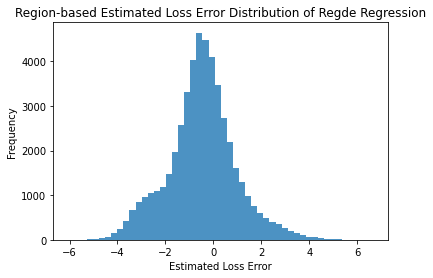

In [31]:
plt.hist(loss_error_rate, bins=50, alpha=0.8, label='boxed-based')
plt.title('Region-based Estimated Loss Error Distribution of Regde Regression')
plt.xlabel('Estimated Loss Error')
plt.ylabel('Frequency')
plt.show()

In [20]:
expected_losses.min(), expected_losses.max()

(0.09817000761821237, 6.945195486839343)

In [21]:
true_losses.min(), true_losses.max()

(1.977026113308966e-05, 9.686885833740234)